# How does the wavelength calibration affect the fringe properties?  
Though the fringe pattern was previously shown in pixel space, each pixel has a corresponding wavelength as per the grating equation. Interference depends on wavelength, thus we want to use the pixel-to-wavelength calibration information to translate the fringe pattern onto a more relevant axis. This also allows us to compare spectra from different parts of the detector, whilst taking into account the geometric effects introduced by the optics, including the different slicer projection angles, and the optical distortion.  
  
Note that the analysis of the PAAH semi-extended source is omitted for now. Additionally, due to the MRS sampling of the PSF, the fringe analysis (and comparative study) of point sources is difficult to do without fitting a spatial profile to the source. As such, the examination of the fringes of point sources is done separately in the next notebook in the series.

## > Import modules

In [1]:
import funcs
import mrsobs

from matplotlib import pyplot as plt
%matplotlib notebook

## > Get data
We load the images for one band of the MRS for different kinds of sources, including:  
* MTS 800K BB extended source
* MIRI 800K BB internal calibration source
* MTS 800K BB extended source observed through etalon "ET1A"  
  
Additionally the pixel-to-wavelength calibration map and the pixel-to-along-slice position map are imported.

In [2]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'distortionMaps/'
lvl2path  = workDir+'FM_data/LVL2/'

# Get data
band = '1A'
ext_source_sci,ext_source_bkg   = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='800K')
intcal_source_sci               = mrsobs.MIRI_internal_calibration_source(lvl2path,band,campaign='FM')
etal_source_sci,etal_source_bkg = mrsobs.FM_MTS_800K_BB_extended_source_through_etalon(lvl2path,band,etalon='ET1A')

# Get wavelength calibration pixel map
d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
lambdaMap = d2cMaps['lambdaMap']
alphaMap = d2cMaps['alphaMap']
nslices   = d2cMaps['nslices']

## > Transform data
We subtract background exposures where available (Contamination Control Cover closed for internal calibration source observations, no background exposures taken)

In [3]:
# perform transform
ext_source_bkgsubtr  = ext_source_sci-ext_source_bkg
etal_source_bkgsubtr = etal_source_sci-etal_source_bkg

## > Modeling
### Test 1: We extract a detector pixel trace in each projected slice on the detector, at an along-slice position of 0. arcseconds. We seek to compare the spectra extracted from different locations on the detector using the wavelength calibration information as common basis for the measurements.

In [10]:
wavelength,ext_source_spectra,intcal_source_spectra,etal_source_spectra = {},{},{},{}
for sliceID in range(1,nslices+1):
    # Pixel trace in MRS slice
    ypos,xpos   = funcs.detpixel_trace(band,d2cMaps,sliceID=sliceID,alpha_pos=0.)
    
    # extracted wavelength range and spectra
    wavelength['slice'+str(sliceID)]            = lambdaMap[ypos,xpos]
    ext_source_spectra['slice'+str(sliceID)]    = ext_source_bkgsubtr[ypos,xpos]
    intcal_source_spectra['slice'+str(sliceID)] = intcal_source_sci[ypos,xpos]
    etal_source_spectra['slice'+str(sliceID)]   = etal_source_bkgsubtr[ypos,xpos]

<IPython.core.display.Javascript object>


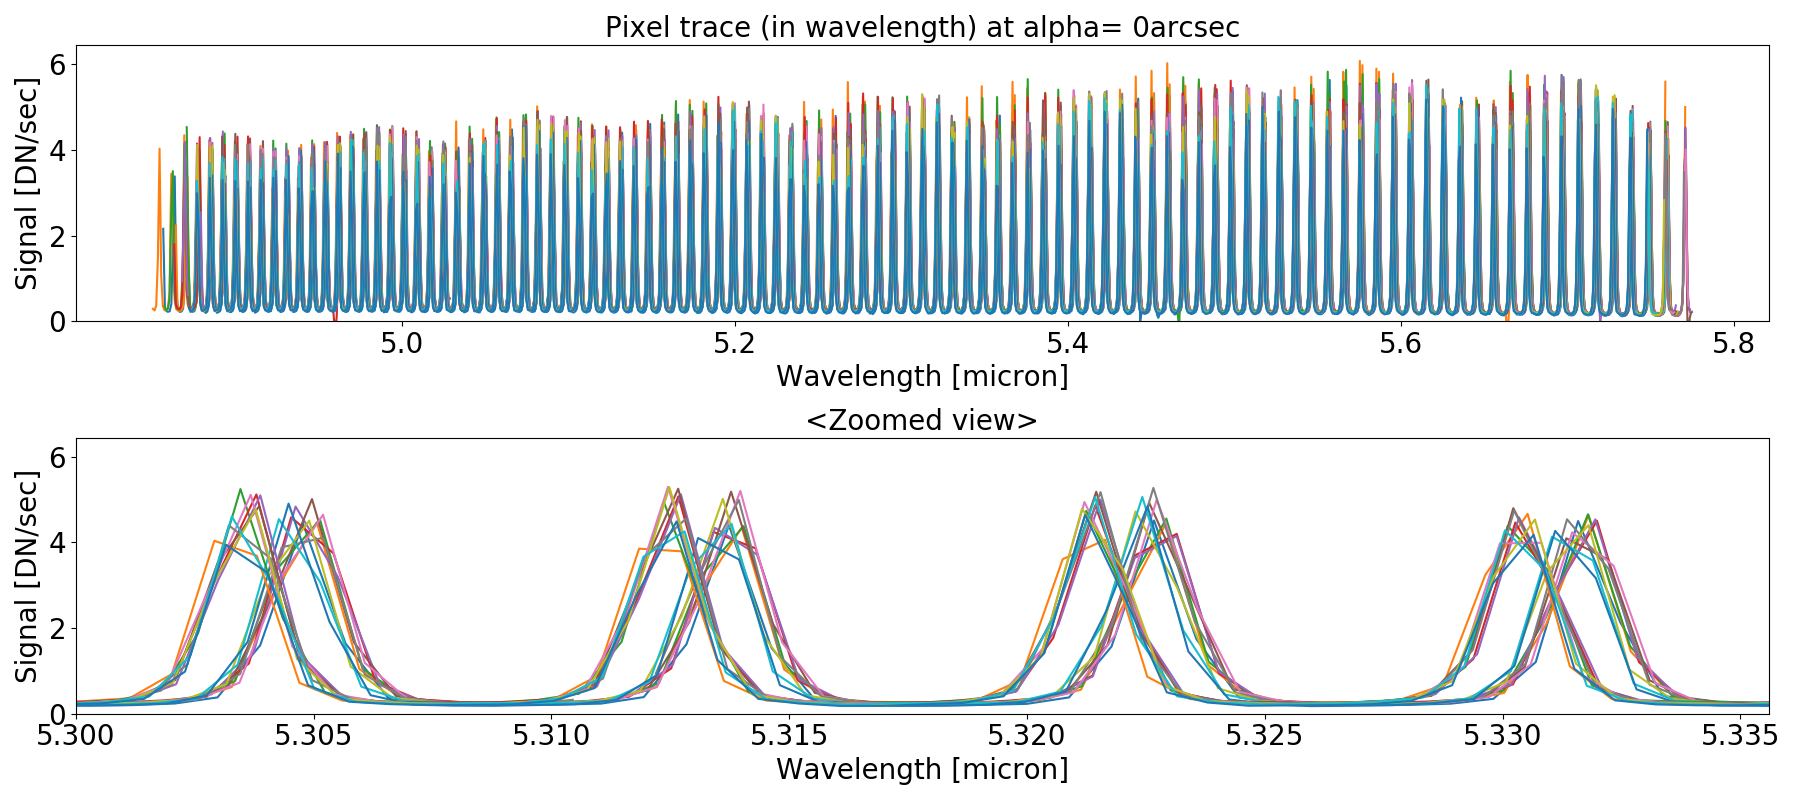

In [11]:
# Let's look at the result
fig,axs=plt.subplots(2,1,figsize=(18,8))
for sliceID in range(1,nslices+1):
    key = 'slice'+str(sliceID)
    axs[0].plot(wavelength[key],etal_source_spectra[key])
    axs[1].plot(wavelength[key],etal_source_spectra[key])
axs[0].set_ylim(0)
axs[0].set_title('Pixel trace (in wavelength) at alpha= 0arcsec',fontsize=20)
axs[0].set_xlabel('Wavelength [micron]',fontsize=20)
axs[0].set_ylabel('Signal [DN/sec]',fontsize=20)
axs[0].tick_params(axis='both',labelsize=20)
axs[1].set_xlim(5.3,5.3356)
axs[1].set_ylim(0)
axs[1].set_title('<Zoomed view>',fontsize=20)
axs[1].set_xlabel('Wavelength [micron]',fontsize=20)
axs[1].set_ylabel('Signal [DN/sec]',fontsize=20)
axs[1].tick_params(axis='both',labelsize=20)
plt.tight_layout()

### Remarks:  
* The etalon lines *should* overlap. They don't, which means that there must be a TBD constant/differential error in the wavelength calibration when comparing pixels traces in different slices.
* The seems to be "clumping" of etalon lines around two distinct positions in wavelength, and this seems to be dependent on the slice that is looked at. We find a discrepancy between the wavelength solution connected to the upper and the lower half of the slicer, as shown below. This means that etalon lines in slices 1 to 11 match, and lines in slices 12 to 21 match, however the two groups are offset. The overall difference is of the order of 2 pixels.

<IPython.core.display.Javascript object>


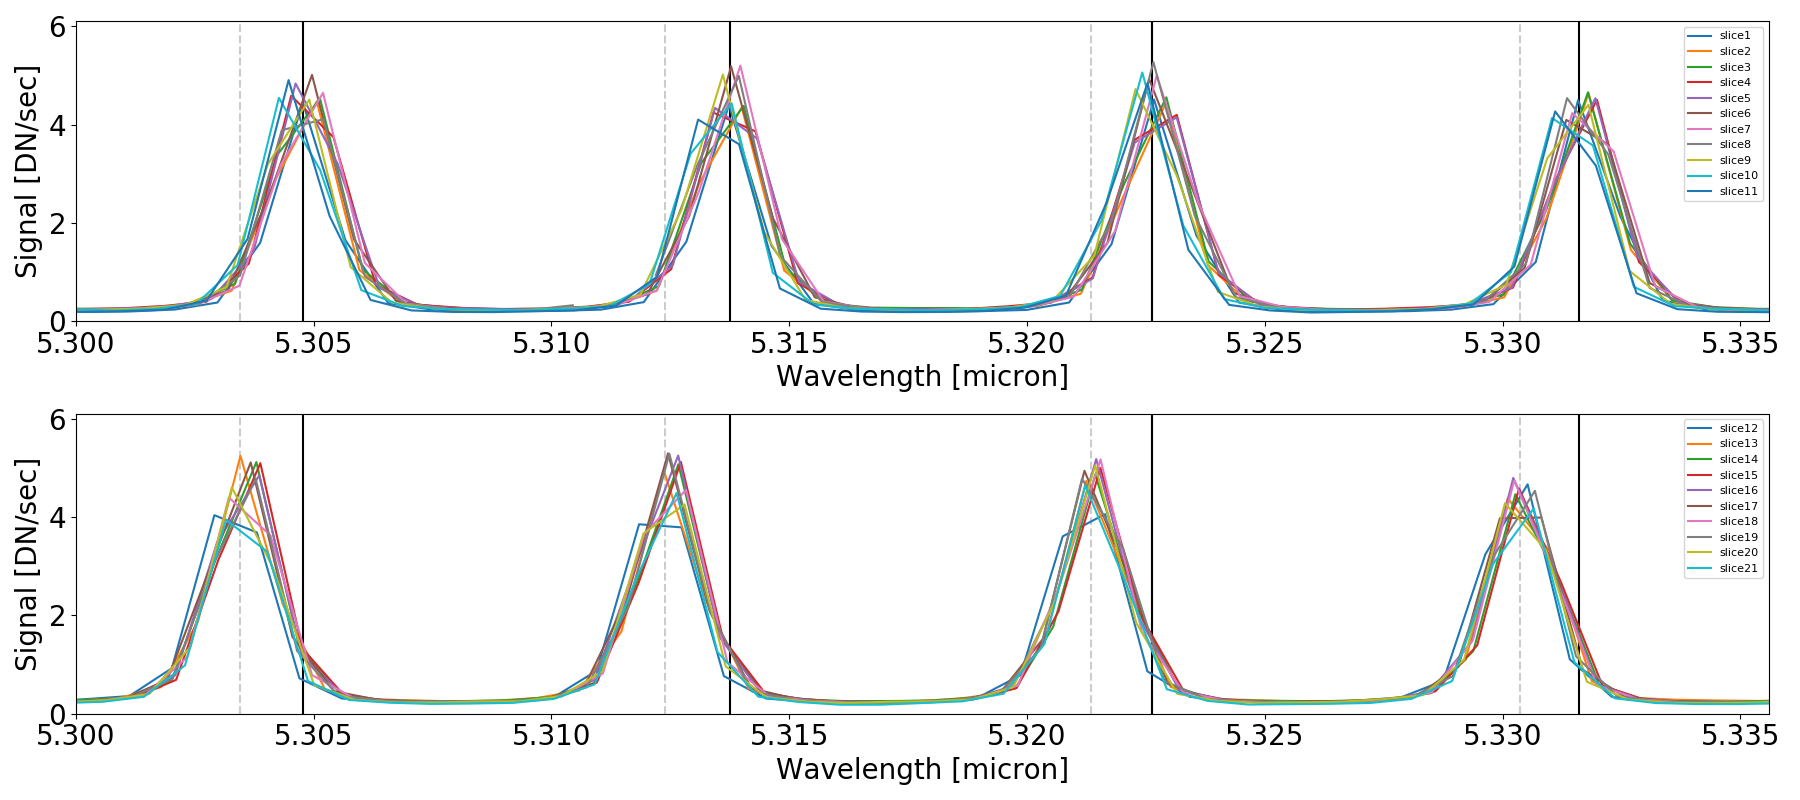

In [12]:
fig,axs=plt.subplots(2,1,figsize=(18,8))
for sliceID in [1,2,3,4,5,6,7,8,9,10,11]:
    key = 'slice'+str(sliceID)
    axs[0].plot(wavelength[key],etal_source_spectra[key],label=key)
for sliceID in [12,13,14,15,16,17,18,19,20,21]:
    key = 'slice'+str(sliceID)
    axs[1].plot(wavelength[key],etal_source_spectra[key],label=key)
axs[0].vlines([5.30477,5.31375,5.32262,5.3316],0,6.1)
axs[0].vlines([5.30346,5.31238,5.32134,5.33036],0,6.1,'gray',alpha=0.4,linestyle='dashed')
axs[0].set_xlim(5.3,5.3356)
axs[0].set_ylim(0,6.1)
axs[0].set_xlabel('Wavelength [micron]',fontsize=20)
axs[0].set_ylabel('Signal [DN/sec]',fontsize=20)
axs[0].legend(loc='upper right',fontsize=8)
axs[0].tick_params(axis='both',labelsize=20)
axs[1].vlines([5.30477,5.31375,5.32262,5.3316],0,6.1)
axs[1].vlines([5.30346,5.31238,5.32134,5.33036],0,6.1,'gray',alpha=0.4,linestyle='dashed')
axs[1].set_xlim(5.3,5.3356)
axs[1].set_ylim(0,6.1)
axs[1].set_xlabel('Wavelength [micron]',fontsize=20)
axs[1].set_ylabel('Signal [DN/sec]',fontsize=20)
axs[1].legend(loc='upper right',fontsize=8)
axs[1].tick_params(axis='both',labelsize=20)
plt.tight_layout()

### Test 2: Due to the wavelength offset (i.e. error) between the two halves of the slicer, we do an intercomparison of the spectra and their fringe patterns only within one half of the slices.

<IPython.core.display.Javascript object>


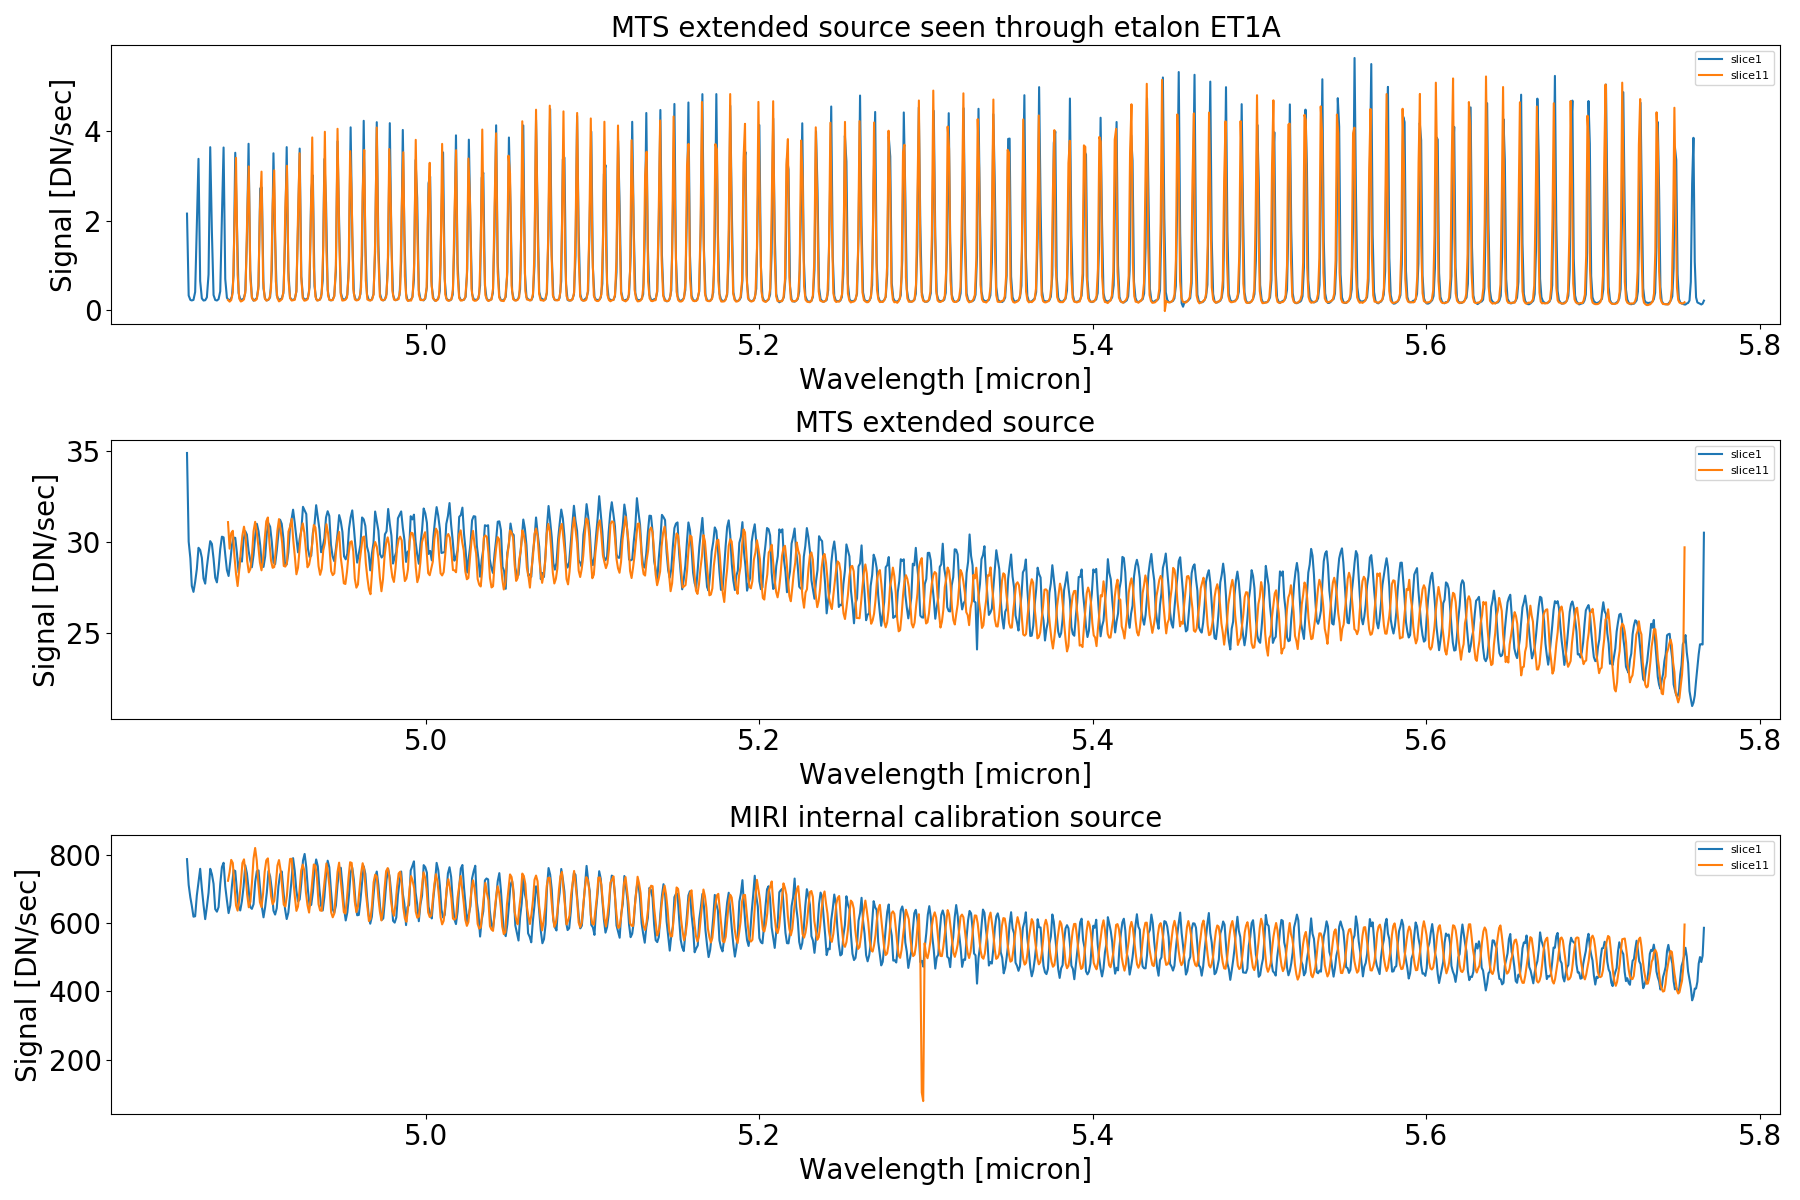

In [13]:
fig,axs=plt.subplots(3,1,figsize=(18,12))
for sliceID in [1,11]:
    key = 'slice'+str(sliceID)
    axs[0].plot(wavelength[key],etal_source_spectra[key],label=key)
    axs[1].plot(wavelength[key],ext_source_spectra[key],label=key)
    axs[2].plot(wavelength[key],intcal_source_spectra[key],label=key)
axs[0].set_title('MTS extended source seen through etalon ET1A',fontsize=20)
axs[0].set_xlabel('Wavelength [micron]',fontsize=20)
axs[0].set_ylabel('Signal [DN/sec]',fontsize=20)
axs[0].legend(loc='upper right',fontsize=8)
axs[0].tick_params(axis='both',labelsize=20)
axs[1].set_title('MTS extended source',fontsize=20)
axs[1].set_xlabel('Wavelength [micron]',fontsize=20)
axs[1].set_ylabel('Signal [DN/sec]',fontsize=20)
axs[1].legend(loc='upper right',fontsize=8)
axs[1].tick_params(axis='both',labelsize=20)
axs[2].set_title('MIRI internal calibration source',fontsize=20)
axs[2].set_xlabel('Wavelength [micron]',fontsize=20)
axs[2].set_ylabel('Signal [DN/sec]',fontsize=20)
axs[2].legend(loc='upper right',fontsize=8)
axs[2].tick_params(axis='both',labelsize=20)
plt.tight_layout()

### Remarks:
* Looking at the top etalon spectrum, the offset between nearby lines is not constant. In fact it increases towards longer wavelengths, which implies a linear (marginal) discrepancy in the 4D polynomial description of the wavelength calibration map.
* The distance between nearby etalon lines in the two different slices is small, and can be accounted for by a small correction. However this correction (and its direction) cannot explain the difference in the fringe pattern seen in the bottom plot. As such we say that the latter cannot be due to the wavelength calibration, and thus must be caused by the geometric properties of the optical system causing the fringes.

### Test 3: We extract a detector pixel trace in a single slice on the detector, at various along-slice positions, and compare the extracted etalon extended source spectra and extended source spectra.

In [8]:
sliceID = 11
alpha_positions = funcs.slice_alphapositions(band,d2cMaps,sliceID=sliceID)

wavelength,ext_source_spectra,intcal_source_spectra,etal_source_spectra = {},{},{},{}
counter = 0
for alpha_pos in alpha_positions:
    counter +=1
    # Pixel trace in MRS slice
    ypos,xpos   = funcs.detpixel_trace(band,d2cMaps,sliceID=11,alpha_pos=alpha_pos)
    
    # extracted wavelength range and spectra
    wavelength['pos'+str(counter)]            = lambdaMap[ypos,xpos]
    ext_source_spectra['pos'+str(counter)]    = ext_source_bkgsubtr[ypos,xpos]
    intcal_source_spectra['pos'+str(counter)] = intcal_source_sci[ypos,xpos]
    etal_source_spectra['pos'+str(counter)]   = etal_source_bkgsubtr[ypos,xpos]

<IPython.core.display.Javascript object>


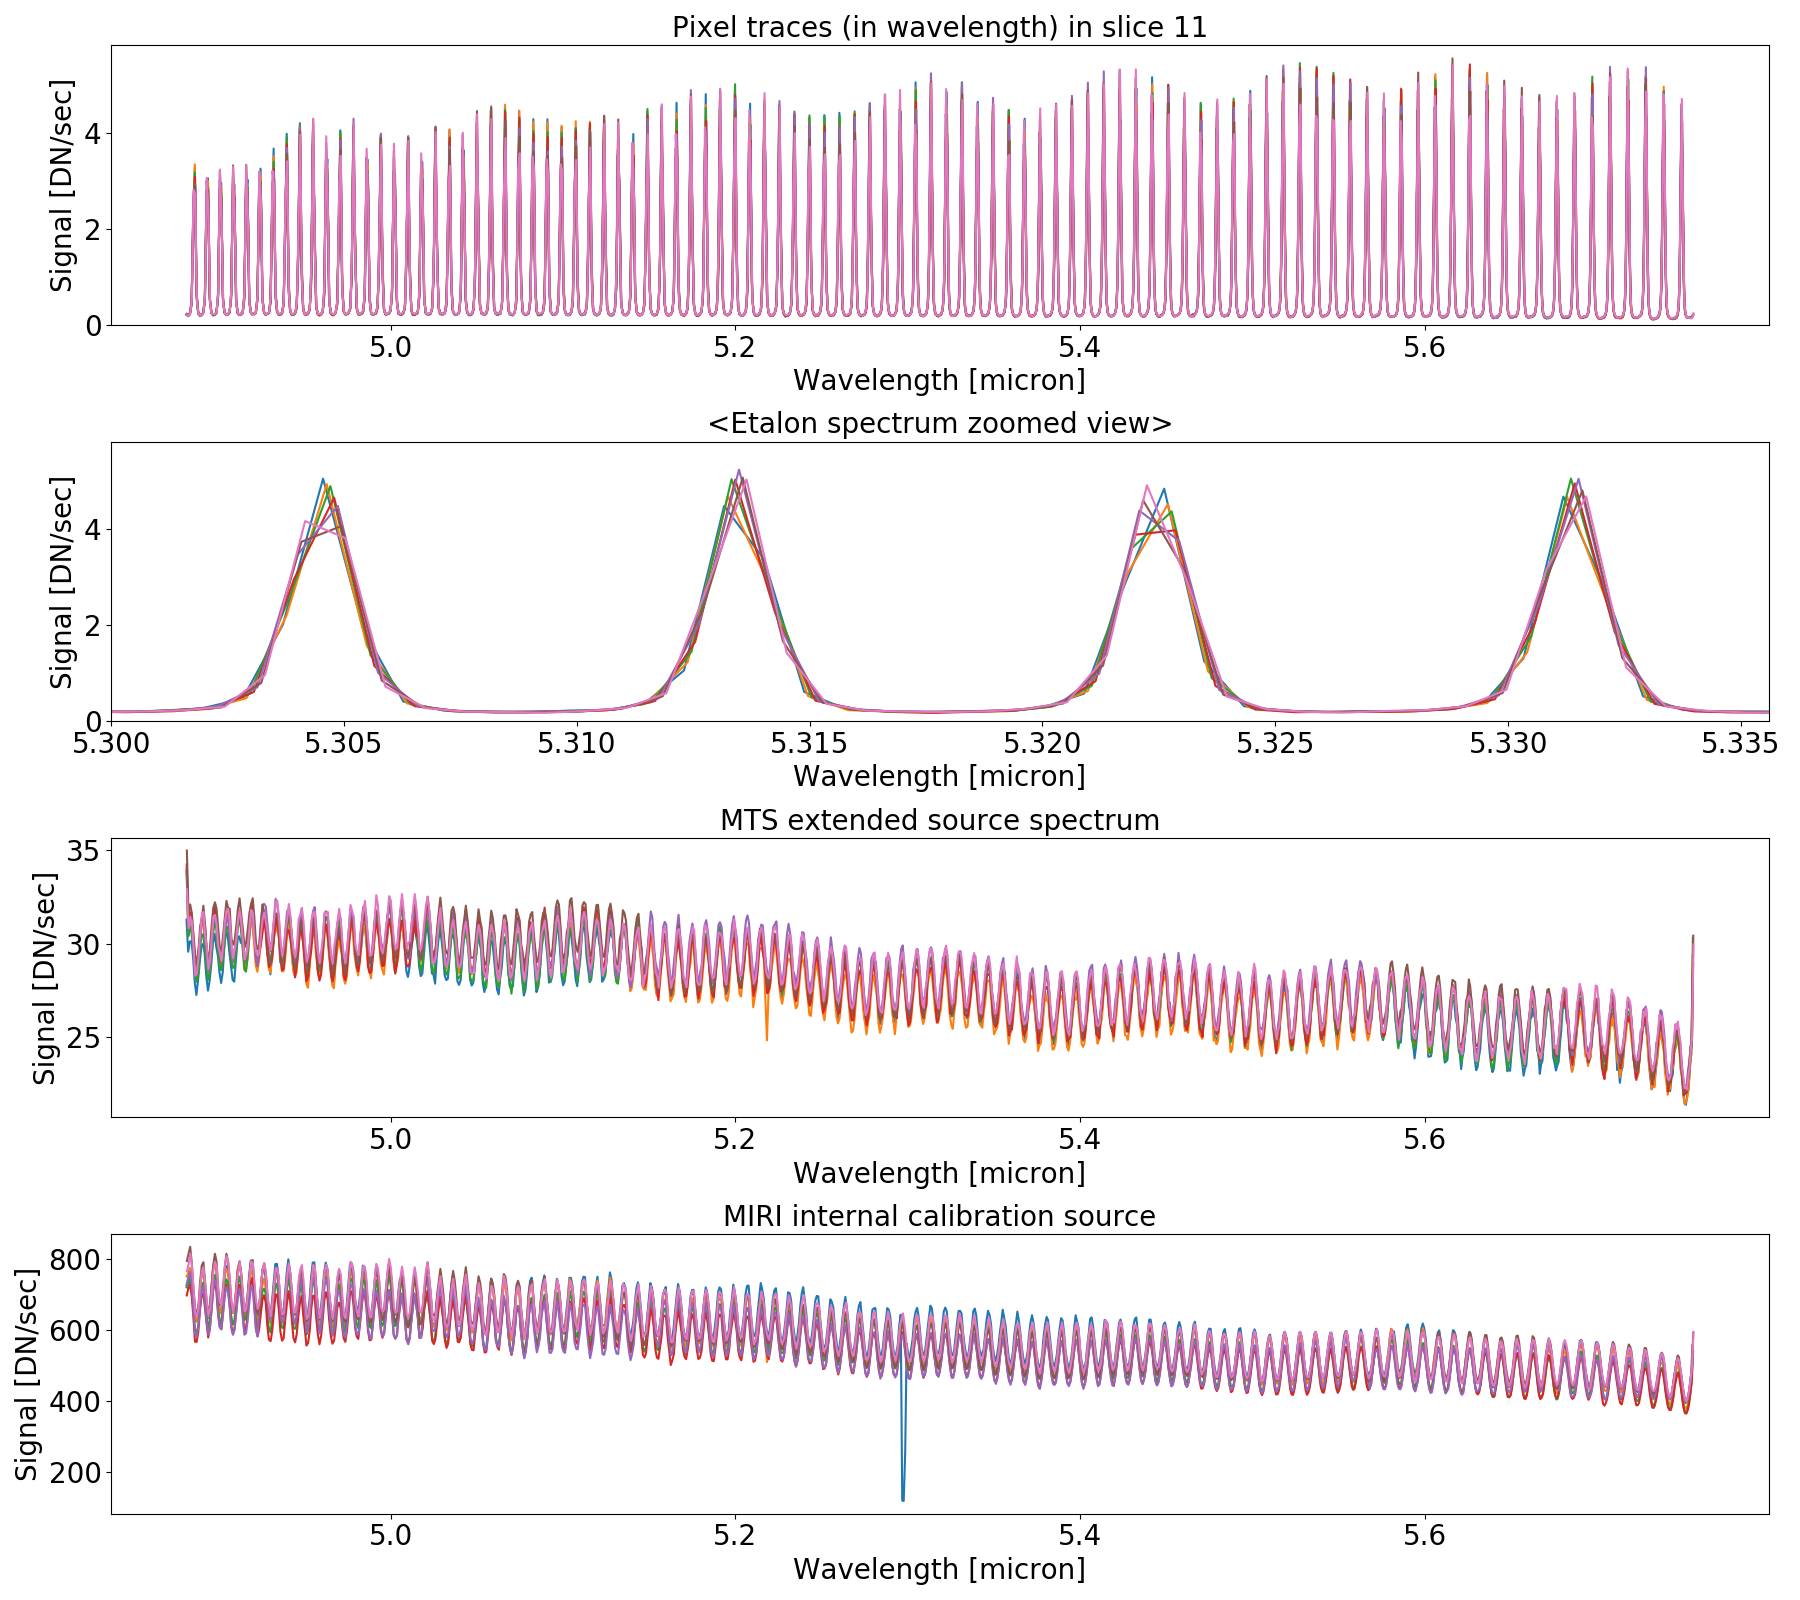

In [9]:
# Let's look at the result
fig,axs=plt.subplots(4,1,figsize=(18,16))
for counter in range(8,len(alpha_positions)-8):
    key = 'pos'+str(counter)
    axs[0].plot(wavelength[key],etal_source_spectra[key])
    axs[1].plot(wavelength[key],etal_source_spectra[key])
    axs[2].plot(wavelength[key],ext_source_spectra[key])
    axs[3].plot(wavelength[key],intcal_source_spectra[key])
axs[0].set_ylim(0)
axs[0].set_title('Pixel traces (in wavelength) in slice {}'.format(sliceID),fontsize=20)
axs[0].set_xlabel('Wavelength [micron]',fontsize=20)
axs[0].set_ylabel('Signal [DN/sec]',fontsize=20)
axs[0].tick_params(axis='both',labelsize=20)
axs[1].set_xlim(5.3,5.3356)
axs[1].set_ylim(0)
axs[1].set_title('<Etalon spectrum zoomed view>',fontsize=20)
axs[1].set_xlabel('Wavelength [micron]',fontsize=20)
axs[1].set_ylabel('Signal [DN/sec]',fontsize=20)
axs[1].tick_params(axis='both',labelsize=20)
axs[2].set_title('MTS extended source spectrum',fontsize=20)
axs[2].set_xlabel('Wavelength [micron]',fontsize=20)
axs[2].set_ylabel('Signal [DN/sec]',fontsize=20)
axs[2].tick_params(axis='both',labelsize=20)
axs[3].set_title('MIRI internal calibration source',fontsize=20)
axs[3].set_xlabel('Wavelength [micron]',fontsize=20)
axs[3].set_ylabel('Signal [DN/sec]',fontsize=20)
axs[3].tick_params(axis='both',labelsize=20)
plt.tight_layout()

### Remarks:
* Within a single slice, at different along-slice positions, the etalon lines overlap. As such it is expected that any change in the fringe pattern is not related to wavelength calibration errors.
* The fringe pattern in the extended source spectrum and the internal calibration spectrum stays largely constant.

## Conclusions:  
* The available wavelength calibration allows for the comparison of extracted spectra in different across and along-slice positions (different slices = different across-slice positions).  
* There is a non-negligible discrepancy in the wavelength calibration between slices 1-11 and 12-21 (MRS band 1A). This means that, unless corrected, any fringe comparisons between the two groups of slices is invalid.
* Within the slice groups 1-11 or 12-21, the wavelength calibration is consistent when comparing different slices (marginal linear correction to wavelength calibration could be applied). As such the fringe pattern is thus not accounted for by wavelength calibration differences.
* Within a single slice, at different along-slice positions, the wavelength calibration is consistent. Any difference in the fringe pattern (again) is thus not accounted for by wavelength calibration differences.
  
## Follow-up question:  
How can we compare solely the fringe transmission seen for different sources (including PSF-subsampled point sources) whilst disregarding the intrinsic spectral baseline of these sources? 